## 트랜스포머로 만드는 대화형 챗봇

### 학습 목표
- 트랜스포머의 인코더 디코더 구조 이해하기
- 내부 단어 토크나이저 사용하기
- 셀프 어텐션 이해하기
- 한국어에도 적용해보기

### 루브릭 
-  한국어 전처리를 통해 학습 데이터셋을 구축하였다. : **공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.**
- 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. : **구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.**
- 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. : **한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.**

## 목차
### 1. 한국어 데이터 수집 및 전처리
#### 1) 데이터 로드
#### 2) 전처리 및 정수 인코딩
#### 3) 입력 데이터셋 구성
### 2. 모델 구성
#### 1) 포지셔널 인코딩, 멀티 헤드 어텐션, 마스킹
#### 2) 인코더/디코더/트랜스포머 함수 구현
#### 3) 손실함수/학습률 지정
### 3. 모델 평가
#### 1) 모델 생성 및 컴파일, 훈련
#### 2) 문장 테스트
---

## 1. 한국어 데이터 수집 및 전처리
### 1) 데이터 로드

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
path_to_dataset = os.getenv('HOME')+'/data'
path_to_conversations = os.path.join(path_to_dataset, 'ChatbotData .csv')
conversations = pd.read_csv(path_to_conversations)
conversations.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [12]:
# 결측값 확인
conversations.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [13]:
# 문장 갯수 확인
len(conversations)

11823

In [14]:
questions = conversations['Q']
answers = conversations['A']

In [15]:
print('20번째 질문: {}'.format(questions[19]))
print('20번째 답변: {}'.format(answers[19]))

20번째 질문: 가스비 너무 많이 나왔다.
20번째 답변: 다음 달에는 더 절약해봐요.


챗봇을 구성하기 위한 데이터셋은 질문-답변의 쌍으로 이루어진 병렬 데이터로 구성되어야 한다. 불러온 데이터셋에는 질문-답변의 쌍이 총 11823개가 존재하고, 각각의 질문과 답변은 같은 index로 짝지어져있다. 질문과 답변을 각각 'questions'와 'answers'로 저장한다.

### 2) 전처리 및 정수 인코딩

In [16]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)    # (가-힣, 0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    # 단어와 구두점("?",".","!",",") 사이에 공백 두기(토큰화에 방해가 되지 않도록)
    sentence = re.sub(r'[" "]+', " ", sentence)    # 공백이 여러번 반복되면 한번으로 줄임
    sentence = sentence.strip()    # 문장 양옆의 공백 제거
    return sentence

In [17]:
Q, A = [], []

for i in range(len(conversations)):
    a = preprocess_sentence(questions[i])
    Q.append(a)
    b = preprocess_sentence(answers[i])
    A.append(b)

In [49]:
print('20번째 전처리 된 질문: {}'.format(Q[19]))
print('20번째 전처리 된 답변: {}'.format(A[19]))

20번째 전처리 된 질문: 가스비 너무 많이 나왔다 .
20번째 전처리 된 답변: 다음 달에는 더 절약해봐요 .


한글, 숫자, 구두점(. , ! ?)을 제외한 모든 문자를 공백으로 처리하고, 구두점과 단어가 한꺼번에 같은 단어로 인식되지 않도록 사이에 공백을 입력하는 등의 전처리를 수행한다.

In [18]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(Q + A, target_vocab_size=2**13)

In [19]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]    # 시작과 종료 토큰에 고유한 정수 부여
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

VOCAB_SIZE = tokenizer.vocab_size + 2    # 시작 토큰과 종료 토큰이 추가된만큼 +2를 하여 단어장의 크기를 산정
print('단어장의 크기:' ,VOCAB_SIZE)

START_TOKEN의 번호 : [8156]
END_TOKEN의 번호 : [8157]
단어장의 크기: 8158


In [20]:
print('정수 인코딩 후의 20번째 질문 샘플: {}'.format(tokenizer.encode(Q[19])))
print('정수 인코딩 후의 20번째 답변 샘플: {}'.format(tokenizer.encode(A[19])))

정수 인코딩 후의 20번째 질문 샘플: [5756, 612, 6, 19, 3106, 55, 1]
정수 인코딩 후의 20번째 답변 샘플: [2354, 7499, 7, 6262, 97, 1]


In [50]:
print(tokenizer.decode([5756]), tokenizer.decode([612]), tokenizer.decode([6]), tokenizer.decode([19]), tokenizer.decode([3106]), tokenizer.decode([55]), tokenizer.decode([1]))

가스 비  너무  많이  나왔 다  .


In [51]:
print(tokenizer.decode([2354]), tokenizer.decode([7499]), tokenizer.decode([7]), tokenizer.decode([6262]), tokenizer.decode([97]), tokenizer.decode([1]))

다음  달에는  더  절약해 봐요  .


토크나이저로 한국어 형태소 분석기가 아닌 내부 단어 토크나이저 SubwordTextEncoder를 사용했을 때, 조사 분리가 엄밀하지는 않으나('달에는'은 '달'과 '에는' 두 단어로 나눠져야 의미 단위대로 단어를 분리했다고 할 수 있다) '가스비'를 '가스', '비'로 분리하는 등, 띄어쓰기하지 않은 단어도 부분적으로 의미 단위를 구분하고 있는 것을 알 수 있다.

질문 길이 최소값: 1
질문 길이 최대값: 16
질문 길이 평균: 3.9371563900871185
질문 길이 중앙값: 4.0
답변 길이 최소값: 1
답변 길이 최대값: 24
답변 길이 평균: 4.715300685105303
답변 길이 중앙값: 4.0


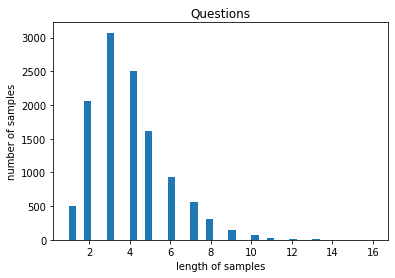

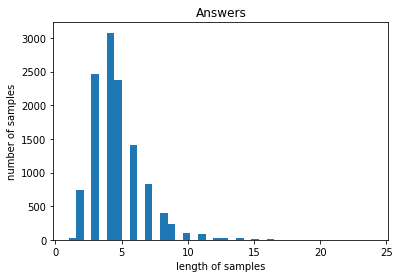

In [21]:
Q_len = [len(s.split()) for s in Q]
A_len = [len(s.split()) for s in A]

print('질문 길이 최소값:', np.min(Q_len))
print('질문 길이 최대값:', np.max(Q_len))
print('질문 길이 평균:', np.mean(Q_len))
print('질문 길이 중앙값:', np.median(Q_len))

print('답변 길이 최소값:', np.min(A_len))
print('답변 길이 최대값:', np.max(A_len))
print('답변 길이 평균:', np.mean(A_len))
print('답변 길이 중앙값:', np.median(A_len))

plt.title('Questions')
plt.hist(Q_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answers')
plt.hist(A_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
def below_threshold_len(MAX_LENGTH, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= MAX_LENGTH):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(MAX_LENGTH, (cnt / len(nested_list))))

In [23]:
MAX_LENGTH = 15

below_threshold_len(MAX_LENGTH, Q)
below_threshold_len(MAX_LENGTH, A)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999154190983676
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9990696100820434


일반적으로 3~4단어 수준의 짧은 질문과 대답 데이터가 대부분을 차지한다. 최대 길이를 15단어로 지정하면 대다수의 데이터를 모두 포괄한다.

In [24]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 시작, 종료 토큰을 고려해 최대 길이 MAX_LENGTH+2 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= (MAX_LENGTH+2) and len(sentence2) <= (MAX_LENGTH+2):
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
    # 최대 길이 MAX_LENGTH+2로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=(MAX_LENGTH+2), padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=(MAX_LENGTH+2), padding='post')
    
    return tokenized_inputs, tokenized_outputs

In [25]:
questions, answers = tokenize_and_filter(Q, A)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8158
필터링 후의 질문 샘플 개수: 11722
필터링 후의 답변 샘플 개수: 11722


### 3) 입력 데이터셋 구성
tf.data.Dataset은 대량의 데이터를 잠재적으로 큰 요소 집합으로 표현할 수 있는 API이다. 인코더와 디코더의 학습에 알맞게끔 일일이 입력 데이터를 지정해주기보다, tf.data.Dataset을 통해 입력 파이프라인을 구축해두면 훈련 프로세스의 속도가 빨라진다. 

인코더와 디코더의 입력으로 사용되어야 하는 질문과 답변의 쌍을 tf.data.Dataset의 입력으로 넣어준다. 이때 훈련데이터를 랜덤하게 섞기 위해, BUFFER SIZE는 전체 데이터 11722건을 모두 포괄할 수 있는 숫자로 지정해야 한다.[참고](https://helloyjam.github.io/tensorflow/buffer-size-in-shuffle/)

In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 12000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]    # 디코더의 inputs은 questions에 대응되는 target인 answers
    },
    {
        'outputs': answers[:, 1:]    # inputs을 받은 다음의 결과 예측을 학습해야 하므로 outputs로 START_TOKEN이 제거된 answers 받음
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

인코더는 입력받은 텍스트의 의미를 해석해야 하므로, 입력값(inputs)을 'questions'로 지정한다.

반면 디코더가 학습을 진행하기 위해서는 일종의 '모범답안'에 해당하는, 'answers'를 입력값(dec_inputs)과 출력값(outputs)으로 받아야 한다.    
즉, questions에 대응되는 타겟에 해당하는 'answers'를 입력으로 받되 디코더가 다음 단어를 예측해갈 수 있도록 마지막 단어를 제외하여 answer[:,:-1]를 입력값(dec_inputs)으로 지정하고, 시작 토큰 'START_TOKEN'을 제외한 answer[:,1:]를 출력값(outputs)으로 지정한다.

이와 같은 '교사 강요' 학습 방법으로, 잘못된 예측으로 인해 디코더 학습이 비효율적으로 진행되는 것을 예방한다.

## 2. 모델 구성
### 1) 포지셔널 인코딩, 멀티 헤드 어텐션, 마스킹
* 포지셔널 인코딩 레이어: 문장의 모든 단어를 한꺼번에 입력으로 받는 트랜스포머가 단어의 순서를 알 수 있도록 임베딩 벡터에 위치 정보를 더해주기 위해 지정하는 레이어이다. 포지셔널 인코딩의 벡터값은 아래와 같이 짝수 인덱스에는 sine, 홀수 인덱스에는 cosine 함수로 정의된다.
  * $PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{model}})$ 
  * $PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{model}})$   
* 이때 $pos$는 입력 문장에서의 임베딩 벡터의 위치, $i$는 임베딩 벡터 내의 차원의 인덱스, $d_{model}$은 임베딩 벡터의 차원을 의미한다.    
* 포지셔널 인코딩 레이어 = (문장의 최대 길이 × 임베딩 벡터의 차원수($d_{model}$)) 행렬과 같다.

In [27]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], 
                                     i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
    
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

트랜스포머에는 크게 3종류의 어텐션이 사용된다.
* 인코더 셀프 어텐션: **인코더의 입력으로 들어간 문장 내 단어들**의 유사도 구하기
* 디코더 셀프 어텐션: 단어를 1개씩 생성하는 **디코더가 이미 생성한 앞 단어들**과의 유사도 구하기
* 인코더-디코더 어텐션: 디코더의 예측가 더 정확히 예측하게 하기 위해, **인코더에 입력된 단어들과 디코더가 생성한 단어들**의 유사도 구하기    


* 스케일드 닷 프로덕트 어텐션: 단어간의 유사도를 구하는 방법으로, 벡터의 내적값을 계산한 후 특정 숫자로 나누어 스케일링을 시행한 것
* 유사도($\dfrac{QK^T}{\sqrt{d_k}}$)를 소프트맥스 함수에 대입하여 0과 1사이의 값으로 Normalize한 다음, 문장 행렬 $V$와 곱하면 어텐션 값을 얻는다.    
$Attention(Q, K, V) = softmax(\dfrac{QK^T}{\sqrt{d_k}})V$


In [28]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # Q와 K의 닷 프로덕트 결과 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

* 멀티-헤드 어텐션: num_heads만큼 입력 문장 행렬을 쪼개서 어텐션을 수행한 다음 그 값 행렬을 하나로 concatenate함으로써, 각각 다른 관점에서 수행한 어텐션이 도출한 서로 다른 결과를 합하는 것. 한번씩만 어텐션을 수행했을 때 놓칠 수도 있었던 정보를 얻을 수 있다.

In [29]:
# 멀티 헤드 어텐션: 스케일드 닷 프로덕트 어텐션 함수 호출
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

* 마스킹(Masking): 특정 값을 가려 실제 연산에 방해가 되지 않도록 하는 기법

  - 패딩 마스킹(Padding Masking): 숫자가 0인 패딩을 참조하지 않기
  - 룩 어헤드 마스킹(Look-ahead masking): 이전 단어들로부터 다음 단어를 예측하도록 하기 위해 다음 단어 가리기

In [30]:
# 패딩 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [31]:
# 룩 어헤드 마스킹+패딩 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 2) 인코더/디코더/트랜스포머 함수 구현
인코더와 디코더는 둘 다 임베딩 층과 포지셔널 인코딩을 연결하고, 인코더/디코더 층을 쌓아 만든다.    
인코더 층은 '셀프 어텐션'과 '피드 포워드 신경망'이라는 2개의 서브 레이어로 구성된다.

In [32]:
# 인코더 하나의 레이어를 함수로 구현
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs, 
        'key': inputs, 
        'value': inputs, 
        'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [33]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 인코더의 층 쌓아올리기
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

디코더 층은 '셀프 어텐션', '인코더-디코더 어텐션', '피드 포워드 신경망'이라는 3개의 서브 레이어로 구성된다. 인코더-디코더 어텐션의 Query는 디코더의 벡터, Key와 Value가 인코더의 벡터이다.

In [34]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [35]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [36]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,
                         )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,
                         )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 3) 손실함수/학습률 지정

In [37]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH + 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [38]:
# 커스텀 된 학습률:모델학습 초기에 learning rate를 높였다가, 서서히 낮추어가는 기법
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

## 3. 모델 평가
### 1) 모델 생성 및 컴파일, 훈련

In [39]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 1024 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(vocab_size=VOCAB_SIZE,
                    num_layers=NUM_LAYERS,
                    units=UNITS,
                    d_model=D_MODEL,
                    num_heads=NUM_HEADS,
                    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 1024)   18859008    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [40]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH + 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [41]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
184/184 [==============================] - 27s 113ms/step - loss: 3.0176 - accuracy: 0.0894
Epoch 2/50
184/184 [==============================] - 20s 111ms/step - loss: 2.4242 - accuracy: 0.1240
Epoch 3/50
184/184 [==============================] - 20s 109ms/step - loss: 2.2390 - accuracy: 0.1337
Epoch 4/50
184/184 [==============================] - 20s 109ms/step - loss: 2.0518 - accuracy: 0.1439
Epoch 5/50
184/184 [==============================] - 20s 111ms/step - loss: 1.8245 - accuracy: 0.1616
Epoch 6/50
184/184 [==============================] - 20s 111ms/step - loss: 1.5649 - accuracy: 0.1895
Epoch 7/50
184/184 [==============================] - 20s 110ms/step - loss: 1.2802 - accuracy: 0.2246
Epoch 8/50
184/184 [==============================] - 20s 110ms/step - loss: 0.9910 - accuracy: 0.2653
Epoch 9/50
184/184 [==============================] - 20s 110ms/step - loss: 0.7176 - accuracy: 0.3083
Epoch 10/50
184/184 [==============================] - 20s 110ms/step - l

### 2) 문장 테스트

In [42]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [43]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [45]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

In [46]:
sentence_generation('심심해.')

입력 : 심심해.
출력 : 친구들과 연락해보세요 .


'친구들과 연락해보세요 .'

In [48]:
sentence_generation('너는 지금 뭐해?')

입력 : 너는 지금 뭐해?
출력 : 실내 데이트요 .


'실내 데이트요 .'

## 후기

* 하이퍼파라미터 중 D_MODEL만을 늘려가며 자연스러운 응답이 나오는지 테스트해보았다. 256에서도 크게 어색하지는 않았지만, ("오늘 날씨 어때?" -> "나가기 어려울 것 같아요.") 현재 1024에서 가장 자연스러웠다. 단어의 임베딩 차원이 깊어질 수록 어느 정도는 자연스러운 의미 해석과 문장 생성이 가능해지는 듯 하다.
* accuracy는 40% 수준에서 더이상 오르지 않는데, 여기서의 accuracy가 모델이 생성한 문장과 정답('answers')이 유사한 정도라면, 사용자의 질문에 유연하게 답해야 하는 챗봇의 accuracy는 너무 높아서도 곤란할 것 같다. 여기서 accuracy가 정확히 무엇을 의미하는 지, 어느 정도 수준을 목표로 하는 것이 적절할 지 궁금하다. 
* 모델의 개념을 충분히 이해하기, 그것을 구현하기라는 두가지 과제가 있다면, 구현 부분에 있어서 많이 부족함을 느꼈다. 논문을 통해 모델을 구현해보고 개선해보기까지가 최종 목표라면, 코딩 훈련에 많은 보강이 필요하지 않을까 싶다... ~손으로 개념을 쓰면 알아서 코딩해주면 안될까...~